In [1]:
from catboost import CatBoostRegressor
from utils.load import load_data, load_submission
from utils.feature import (
    add_hours,
    add_hours_trig_cyclic,
    apply_feature_engineering,
    get_dummies,
    fill_na_zero,
    drop_non_input_cols,
    normalize,
    standardize
)
from utils.model import ModelEvalWrapper

In [6]:
train_df, predict_df = load_data('../data')

In [7]:
_train_df, _predict_df = apply_feature_engineering(
    train_df,
    predict_df,
    funcs=[
        add_hours,
        fill_na_zero("all"),
        normalize(["txpower_cell0", "txpower_cell1", "txpower_cell2", "txpower_cell3"]),
        standardize(
            [
                "bandwidth_cell0",
                "antennas_cell0",
                "bandwidth_cell1",
                "antennas_cell1",
                "bandwidth_cell2",
                "antennas_cell2",
                "bandwidth_cell3",
                "antennas_cell3",
            ]
        ),
        get_dummies(
            [
                "hour",
                "rutype",
                "mode",
                "frequency_cell0",
                "frequency_cell1",
                "frequency_cell2",
                "frequency_cell3",
            ]
        ),
        drop_non_input_cols,
    ],
)

In [4]:
params = {
    "iterations": 10000,
    "learning_rate": 0.001,
    "depth": 6,
    "loss_function": "MAE",
}

model_getter = lambda: CatBoostRegressor(**params)
model_trainer = lambda model, X, y, *args, **kwargs: model.fit(
    X, y, verbose=False, eval_set=[(kwargs["X_test"], kwargs["y_test"])]
)
model_predictor = lambda model, X: model.predict(X)
model_eval = ModelEvalWrapper(
    model_getter,
    name="Basic Linear Regression",
    model_trainer=model_trainer,
    model_predictor=model_predictor,
)

model_eval.train_and_eval(_train_df)


INFO:root:Fold 1/5
INFO:root:Train MAE: 2.6160, MAPE: 0.0948, MSE: 15.2652
INFO:root:Test MAE: 2.6480, MAPE: 0.0964, MSE: 15.6549
INFO:root:Fold 2/5
INFO:root:Train MAE: 2.6241, MAPE: 0.0952, MSE: 15.3419
INFO:root:Test MAE: 2.6113, MAPE: 0.0936, MSE: 15.2813
INFO:root:Fold 3/5
INFO:root:Train MAE: 2.6195, MAPE: 0.0949, MSE: 15.3243
INFO:root:Test MAE: 2.6433, MAPE: 0.0965, MSE: 15.5776
INFO:root:Fold 4/5
INFO:root:Train MAE: 2.6229, MAPE: 0.0949, MSE: 15.4037
INFO:root:Test MAE: 2.6130, MAPE: 0.0950, MSE: 15.1825
INFO:root:Fold 5/5
INFO:root:Train MAE: 2.6207, MAPE: 0.0951, MSE: 15.3406
INFO:root:Test MAE: 2.6302, MAPE: 0.0953, MSE: 15.3185
INFO:root:
Best model from fold 2
INFO:root:Best model mae: 2.6113, mape: 0.0936 mse: 15.2813

INFO:root:Average mae: 2.6291, mape: 0.0954, mse: 15.4030
INFO:root:Std mae: 0.0151, mape: 0.0010, mse: 0.1814

INFO:root:Analytic evaluations for best model
INFO:root:Error metrics by number of cells in usage
INFO:root:Metrics for 0 cells in usage (87225

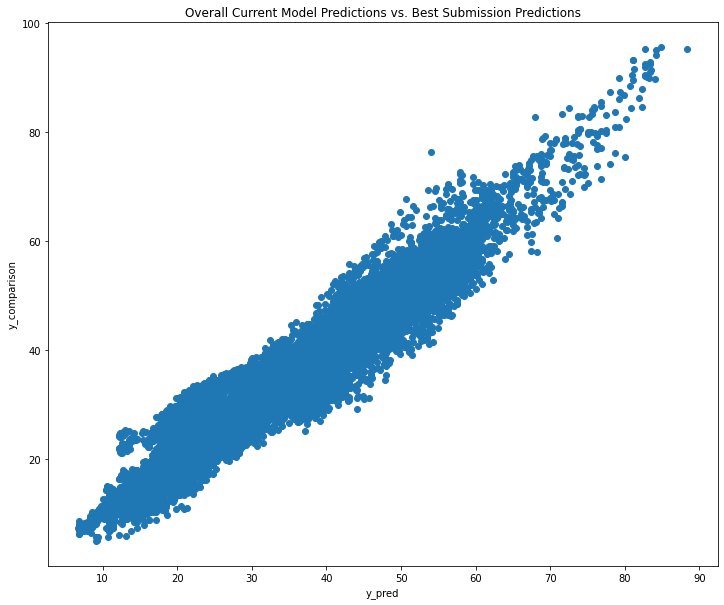

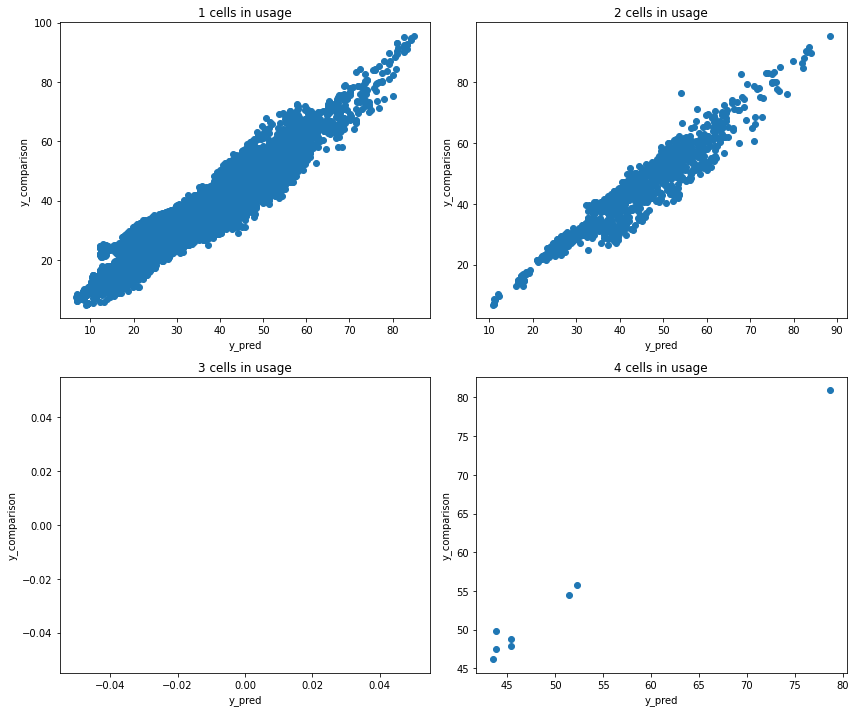

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 10)
best_submission = load_submission("bestsubmission.csv")
model_eval.compare_predictions_with(_predict_df, best_submission['Energy'])